In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import TFRobertaModel, RobertaTokenizer
import itertools
import random

In [25]:
# Load the dataset
df = pd.read_csv('Data/Reviews.csv')

# Map 'Score' to sentiment labels
def map_score_to_label(score):
    if score in [1, 2]:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:  # 4 or 5
        return 2  # Positive

df['label'] = df['Score'].apply(map_score_to_label)

In [26]:
# Balance the dataset by sampling 5000 reviews per class
df_balanced = df.groupby('label').apply(lambda x: x.sample(n=5000, random_state=42)).reset_index(drop=True)

# Clean the text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_balanced['cleaned_text'] = df_balanced['Text'].apply(clean_text)

In [27]:
# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')

# Tokenize the text
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

tokenized_texts = tokenize_function(df_balanced['cleaned_text'])

# Convert tensors to numpy arrays
input_ids = tokenized_texts['input_ids'].numpy()
attention_mask = tokenized_texts['attention_mask'].numpy()
labels = df_balanced['label'].values

# Clear unused variables to save memory
del tokenized_texts, df_balanced

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
# Split into train, validation, and test sets
train_input_ids, temp_input_ids, train_labels, temp_labels, train_attention_mask, temp_attention_mask = train_test_split(
    input_ids,
    labels,
    attention_mask,
    test_size=0.3,  # 70% train, 30% temp
    random_state=42
)

# Further split temp into validation and test sets
val_input_ids, test_input_ids, val_labels, test_labels, val_attention_mask, test_attention_mask = train_test_split(
    temp_input_ids,
    temp_labels,
    temp_attention_mask,
    test_size=0.5,  # 15% validation, 15% test
    random_state=42
)

# Clear unused variables to save memory
del input_ids, attention_mask, labels, temp_input_ids, temp_labels, temp_attention_mask

# Function to create TensorFlow datasets
def create_tf_dataset(input_ids, attention_mask, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': input_ids, 'attention_mask': attention_mask},
        labels
    ))
    dataset = dataset.batch(batch_size)
    return dataset

In [37]:
# Build the model function
def build_model(base_model, activation_function='relu', dropout_rate=0.2, use_batchnorm=False, additional_layers=True):
    # Define inputs
    input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # Get outputs from the base model
    outputs = base_model(input_ids, attention_mask=attention_mask)
    cls_token = outputs[0][:, 0, :]

    if additional_layers:
      # Add new encoding layers
      x = tf.keras.layers.Dense(512)(cls_token)
      if use_batchnorm:
          x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation_function)(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)

      x = tf.keras.layers.Dense(256)(x)
      if use_batchnorm:
          x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation_function)(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)

      x = tf.keras.layers.Dense(128)(x)
      if use_batchnorm:
          x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation_function)(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)

      x = tf.keras.layers.Dense(64)(x)
      if use_batchnorm:
          x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation_function)(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)

      output = tf.keras.layers.Dense(3, activation='softmax')(x)
    else:
      output = tf.keras.layers.Dense(3, activation='softmax')(cls_token)

    # Build the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model

In [38]:
# Function to get optimizer with specified learning rate
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif name == 'adamw':
        try:
            # For TensorFlow 2.11 and above
            return tf.keras.optimizers.experimental.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
        except AttributeError:
            # For earlier versions, use the experimental namespace
            return tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Fallback to Adam if AdamW is not available
    else:
        raise ValueError(f'Unsupported optimizer: {name}')

In [39]:
# Define hyperparameter options
optimizers = ['adam', 'adamw']
learning_rates = [1e-5, 3e-5]
batch_sizes = [16, 32]
dropout_rates = [0.1, 0.2]
activation_functions = ['relu', 'tanh']
use_batchnorm_options = [False] # prevent underfitting

# Limit the number of configurations to manage computational resources
max_configs = 6 # Adjust this number based on your resources
configs = []

for _ in range(max_configs):
    config = {
        'optimizer': random.choice(optimizers),
        'learning_rate': random.choice(learning_rates),
        'batch_size': random.choice(batch_sizes),
        'dropout_rate': random.choice(dropout_rates),
        'activation_function': random.choice(activation_functions),
        'use_batchnorm': random.choice(use_batchnorm_options)
    }
    configs.append(config)

# Load the base RoBERTa model and freeze layers
base_model = TFRobertaModel.from_pretrained('distilroberta-base')
for layer in base_model.layers:
    layer.trainable = False

histories = []
results = []

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [40]:
def run_model(num_epochs, patience, configurations, base_model, additional_layers):

  # Initialize variables to keep track of the best model
  best_accuracy = 0
  best_model = None
  best_config = None
  best_y_pred = None

  # Loop over configurations
  for i, config in enumerate(configurations):
      print(f"Training configuration {i+1}/{len(configurations)}: {config}")

      # Build the model
      model = build_model(
          base_model,
          activation_function=config['activation_function'],
          dropout_rate=config['dropout_rate'],
          use_batchnorm=config['use_batchnorm'],
          additional_layers= additional_layers
      )

      # Get optimizer with specified learning rate
      optimizer = get_optimizer(config['optimizer'], learning_rate=config['learning_rate'])

      # Compile the model
      model.compile(
          optimizer=optimizer,
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      # Create datasets with specified batch size
      batch_size = config['batch_size']
      train_dataset = create_tf_dataset(train_input_ids, train_attention_mask, train_labels, batch_size)
      val_dataset = create_tf_dataset(val_input_ids, val_attention_mask, val_labels, batch_size)
      test_dataset = create_tf_dataset(test_input_ids, test_attention_mask, test_labels, batch_size)

      # Set up callbacks
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

      # Fit the model using the validation set
      history = model.fit(
          train_dataset,
          epochs=num_epochs,
          validation_data=val_dataset,
          callbacks=[early_stopping],
          verbose=1
      )

      # Record the history and config
      histories.append((history, config))

      # Evaluate the final model on the test set
      loss, accuracy = model.evaluate(test_dataset)
      print(f"Test accuracy: {accuracy}")

      # Store results
      results.append({
          'config': config,
          'accuracy': accuracy,
          'loss': loss,
      })

      # Generate predictions for the test set
      y_pred_probs = model.predict(test_dataset)
      y_pred = np.argmax(y_pred_probs, axis=1)

      # Flatten test labels
      y_true = test_labels

      # Compute confusion matrix
      cm = confusion_matrix(y_true, y_pred)

      # Classification report
      report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
      print(f"Classification Report for Configuration {i+1}:\n{report}")

      # Plot confusion matrix
      plt.figure(figsize=(6, 5))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.title(f'Confusion Matrix for Configuration {i+1}')
      plt.show()

      # Store results
      results.append({
          'config': config,
          'accuracy': accuracy,
          'loss': loss,
          'confusion_matrix': cm,
          'classification_report': report
      })

      # If current model is better, save it
      if accuracy > best_accuracy:
          print("New best model found!")
          # Clear previous best model from memory if exists
          if best_model is not None:
              tf.keras.backend.clear_session()
              del best_model

          best_accuracy = accuracy
          best_model = model
          best_config = config
          best_y_pred = y_pred
          best_y_true = y_true
          # Also store confusion matrix and classification report
          best_cm = confusion_matrix(y_true, y_pred)
          best_report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
      else:
          # Clear current model from memory
          tf.keras.backend.clear_session()
          del model
  return best_accuracy, best_model, best_config, best_y_pred, best_y_true, best_cm, best_report

Training configuration 1/6: {'optimizer': 'adamw', 'learning_rate': 3e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': False}
Epoch 1/80
657/657 [==============================] - 73s 101ms/step - loss: 1.0993 - accuracy: 0.3907 - val_loss: 0.9956 - val_accuracy: 0.5182
Epoch 2/80
657/657 [==============================] - 65s 99ms/step - loss: 0.9773 - accuracy: 0.5142 - val_loss: 0.8534 - val_accuracy: 0.6067
Epoch 3/80
657/657 [==============================] - 64s 98ms/step - loss: 0.8854 - accuracy: 0.5789 - val_loss: 0.7991 - val_accuracy: 0.6120
Epoch 4/80
657/657 [==============================] - 64s 98ms/step - loss: 0.8366 - accuracy: 0.6171 - val_loss: 0.7604 - val_accuracy: 0.6422
Epoch 5/80
657/657 [==============================] - 65s 98ms/step - loss: 0.8206 - accuracy: 0.6250 - val_loss: 0.7507 - val_accuracy: 0.6476
Epoch 6/80
657/657 [==============================] - 64s 98ms/step - loss: 0.8045 - accuracy: 0.6375 - val_lo

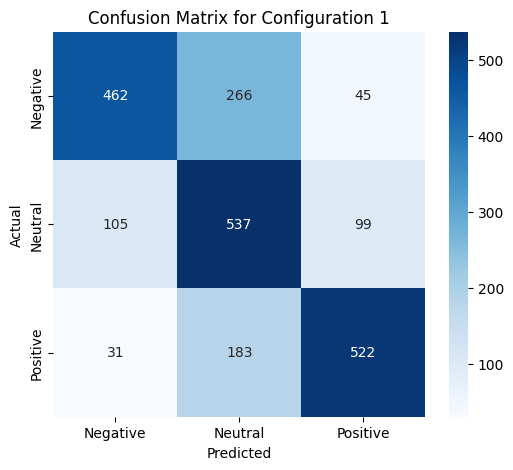

New best model found!
Training configuration 2/6: {'optimizer': 'adamw', 'learning_rate': 3e-05, 'batch_size': 32, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': False}
Epoch 1/80
329/329 [==============================] - 72s 194ms/step - loss: 1.1209 - accuracy: 0.3676 - val_loss: 1.0282 - val_accuracy: 0.5738
Epoch 2/80
329/329 [==============================] - 60s 184ms/step - loss: 1.0380 - accuracy: 0.4625 - val_loss: 0.9283 - val_accuracy: 0.5907
Epoch 3/80
329/329 [==============================] - 61s 186ms/step - loss: 0.9422 - accuracy: 0.5429 - val_loss: 0.8324 - val_accuracy: 0.6298
Epoch 4/80
329/329 [==============================] - 60s 182ms/step - loss: 0.8771 - accuracy: 0.5938 - val_loss: 0.7770 - val_accuracy: 0.6453
Epoch 5/80
329/329 [==============================] - 61s 184ms/step - loss: 0.8437 - accuracy: 0.6037 - val_loss: 0.7508 - val_accuracy: 0.6631
Epoch 6/80
329/329 [==============================] - 60s 183ms/step - loss: 0.8198 

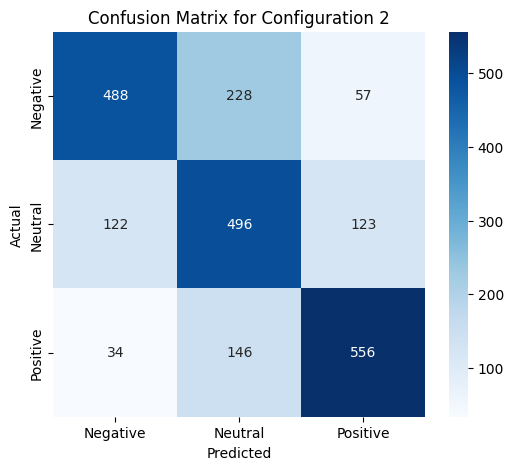

New best model found!
Training configuration 3/6: {'optimizer': 'adamw', 'learning_rate': 1e-05, 'batch_size': 32, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': False}
Epoch 1/80
329/329 [==============================] - 73s 193ms/step - loss: 1.1361 - accuracy: 0.3505 - val_loss: 1.0738 - val_accuracy: 0.4000
Epoch 2/80
329/329 [==============================] - 62s 187ms/step - loss: 1.1099 - accuracy: 0.3741 - val_loss: 1.0474 - val_accuracy: 0.5320
Epoch 3/80
329/329 [==============================] - 60s 183ms/step - loss: 1.0849 - accuracy: 0.4051 - val_loss: 1.0149 - val_accuracy: 0.5960
Epoch 4/80
329/329 [==============================] - 60s 183ms/step - loss: 1.0496 - accuracy: 0.4467 - val_loss: 0.9792 - val_accuracy: 0.6044
Epoch 5/80
329/329 [==============================] - 60s 184ms/step - loss: 1.0173 - accuracy: 0.4775 - val_loss: 0.9390 - val_accuracy: 0.6227
Epoch 6/80
329/329 [==============================] - 60s 184ms/step - loss: 0.9832 

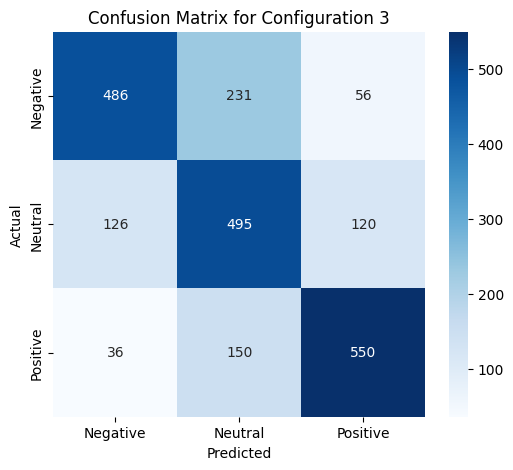

Training configuration 4/6: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 32, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': False}
Epoch 1/80
329/329 [==============================] - 69s 191ms/step - loss: 1.1155 - accuracy: 0.3318 - val_loss: 1.0964 - val_accuracy: 0.3342
Epoch 2/80
329/329 [==============================] - 60s 183ms/step - loss: 1.1025 - accuracy: 0.3490 - val_loss: 1.0937 - val_accuracy: 0.3324
Epoch 3/80
329/329 [==============================] - 62s 187ms/step - loss: 1.0987 - accuracy: 0.3498 - val_loss: 1.0883 - val_accuracy: 0.3840
Epoch 4/80
329/329 [==============================] - 60s 183ms/step - loss: 1.0907 - accuracy: 0.3711 - val_loss: 1.0680 - val_accuracy: 0.4951
Epoch 5/80
329/329 [==============================] - 61s 186ms/step - loss: 1.0743 - accuracy: 0.4113 - val_loss: 1.0329 - val_accuracy: 0.5276
Epoch 6/80
329/329 [==============================] - 60s 183ms/step - loss: 1.0440 - accuracy: 0.4538 - va

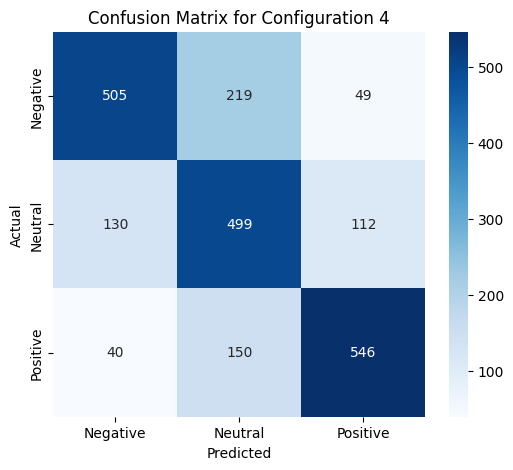

New best model found!
Training configuration 5/6: {'optimizer': 'adam', 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': False}
Epoch 1/80
657/657 [==============================] - 74s 102ms/step - loss: 1.1318 - accuracy: 0.3467 - val_loss: 1.0639 - val_accuracy: 0.4324
Epoch 2/80
657/657 [==============================] - 65s 99ms/step - loss: 1.0935 - accuracy: 0.3970 - val_loss: 1.0220 - val_accuracy: 0.5209
Epoch 3/80
657/657 [==============================] - 64s 98ms/step - loss: 1.0479 - accuracy: 0.4506 - val_loss: 0.9673 - val_accuracy: 0.6080
Epoch 4/80
657/657 [==============================] - 65s 98ms/step - loss: 1.0032 - accuracy: 0.4947 - val_loss: 0.9150 - val_accuracy: 0.6133
Epoch 5/80
657/657 [==============================] - 65s 99ms/step - loss: 0.9579 - accuracy: 0.5386 - val_loss: 0.8674 - val_accuracy: 0.6316
Epoch 6/80
657/657 [==============================] - 65s 98ms/step - loss: 0.9182 - accu

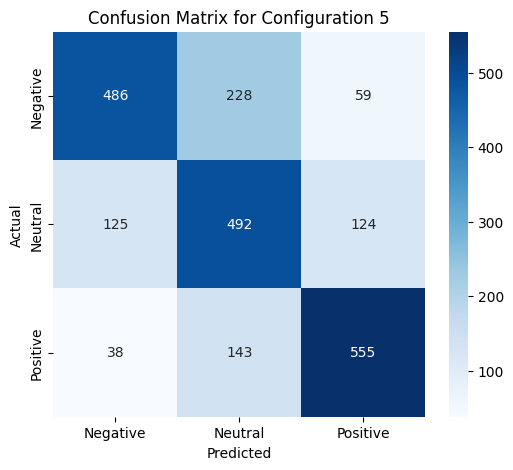

Training configuration 6/6: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 16, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': False}
Epoch 1/80
657/657 [==============================] - 74s 102ms/step - loss: 1.1243 - accuracy: 0.3430 - val_loss: 1.0926 - val_accuracy: 0.3338
Epoch 2/80
657/657 [==============================] - 65s 98ms/step - loss: 1.0952 - accuracy: 0.3697 - val_loss: 1.0708 - val_accuracy: 0.4542
Epoch 3/80
657/657 [==============================] - 65s 99ms/step - loss: 1.0765 - accuracy: 0.4084 - val_loss: 1.0314 - val_accuracy: 0.5991
Epoch 4/80
657/657 [==============================] - 65s 99ms/step - loss: 1.0347 - accuracy: 0.4702 - val_loss: 0.9296 - val_accuracy: 0.6027
Epoch 5/80
657/657 [==============================] - 65s 99ms/step - loss: 0.9706 - accuracy: 0.5165 - val_loss: 0.8441 - val_accuracy: 0.6142
Epoch 6/80
657/657 [==============================] - 65s 99ms/step - loss: 0.9237 - accuracy: 0.5471 - val_los

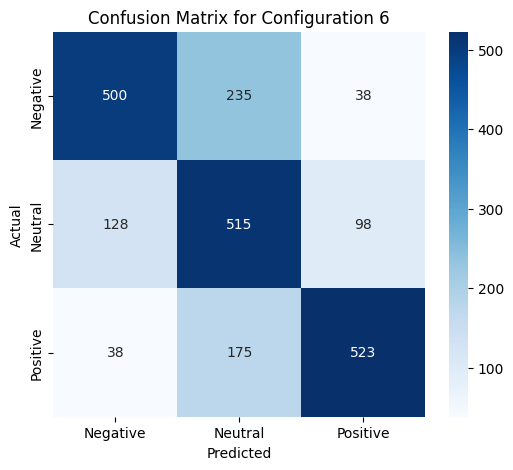

In [41]:
# Run the model
best_accuracy, best_model, best_config, best_y_pred, best_y_true, best_cm, best_report = run_model(num_epochs=80, patience = 4, configurations= configs, base_model=base_model, additional_layers = True)

In [43]:
# After the training loop
print(f"\nBest Model Configuration: {best_config}")
print(f"Best Model Test Accuracy: {best_accuracy}")

# Use the best model's predictions
y_pred = best_y_pred
y_true = best_y_true

# Identify misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]

# Decode test texts
def decode_texts(input_ids):
    return [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

test_texts = decode_texts(test_input_ids)

# Extract false positives and false negatives
false_positives = []
false_negatives = []

# Mapping of label indices to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Loop through misclassified examples to separate false positives and false negatives
for idx in misclassified_indices:
    true_label = y_true[idx]
    predicted_label = y_pred[idx]
    text = test_texts[idx]

    if predicted_label == 2 and true_label != 2:
        # Model predicted Positive, but true label is Negative or Neutral
        false_positives.append((text, label_map[true_label], label_map[predicted_label]))
    elif predicted_label != 2 and true_label == 2:
        # Model predicted Negative or Neutral, but true label is Positive
        false_negatives.append((text, label_map[true_label], label_map[predicted_label]))

# Display a few examples of false positives
print("\nExamples of False Positives:")
for i in range(min(3, len(false_positives))):
    text, true_label, predicted_label = false_positives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")

# Display a few examples of false negatives
print("\nExamples of False Negatives:")
for i in range(min(3, len(false_negatives))):
    text, true_label, predicted_label = false_negatives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")


Best Model Configuration: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 32, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': False}
Best Model Test Accuracy: 0.6888889074325562

Examples of False Positives:

Text: this is quite good ive taken to starting my mornings with a nice hot mug
True Label: Neutral
Predicted Label: Positive

Text: i love gloria jeans cinnamon nut strudel coffee and decided to try this the flavoring is a little over powering for me if youve tried this flavor before and like it you wont be disappointed with it in the kcups packaging
True Label: Neutral
Predicted Label: Positive

Text: we love clif kid z bars i decided to try these based on all of the great reviews we bought the strawberry and no one in the house likes them my kids are picky so i always try the treats just to see if they are even worth trying i eat healthy and dont mind most healthy snacks but even i did not care for these i am going to try another flavor but the 

In [45]:
# Save the best model to a .keras file
best_model.save('best_model.keras')
print("\nBest model saved to 'best_model.keras'.")

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)



Best model saved to 'best_model.keras'.


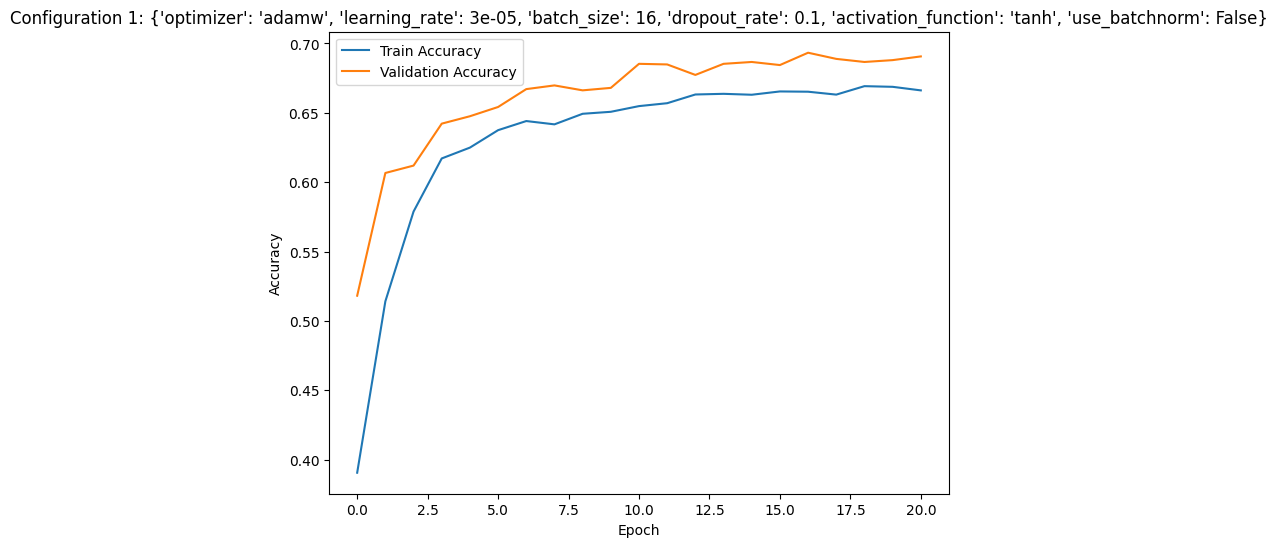

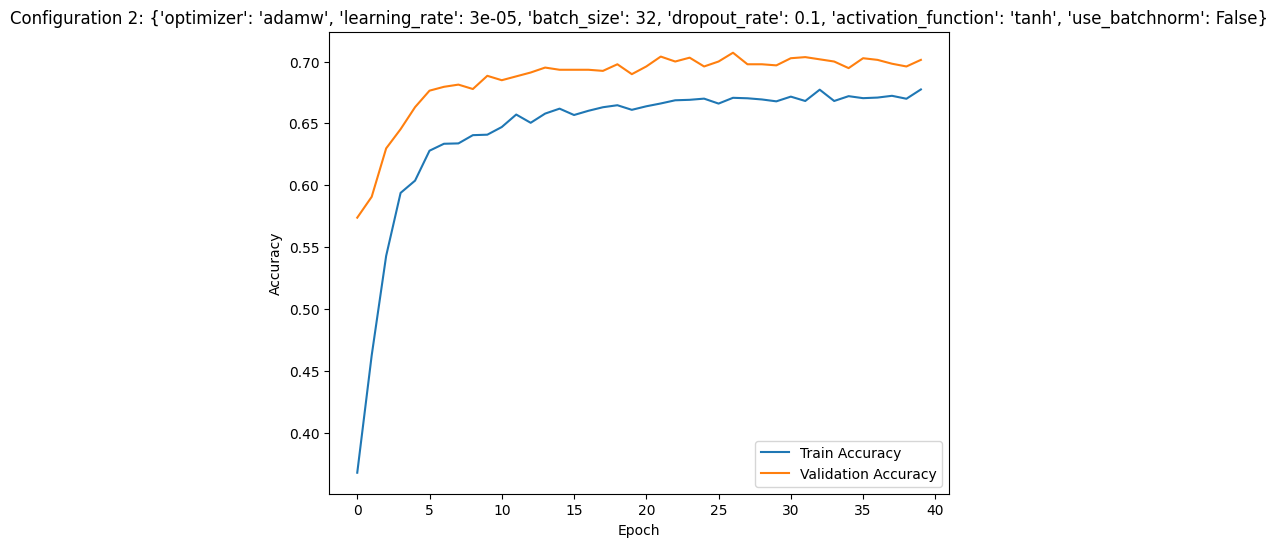

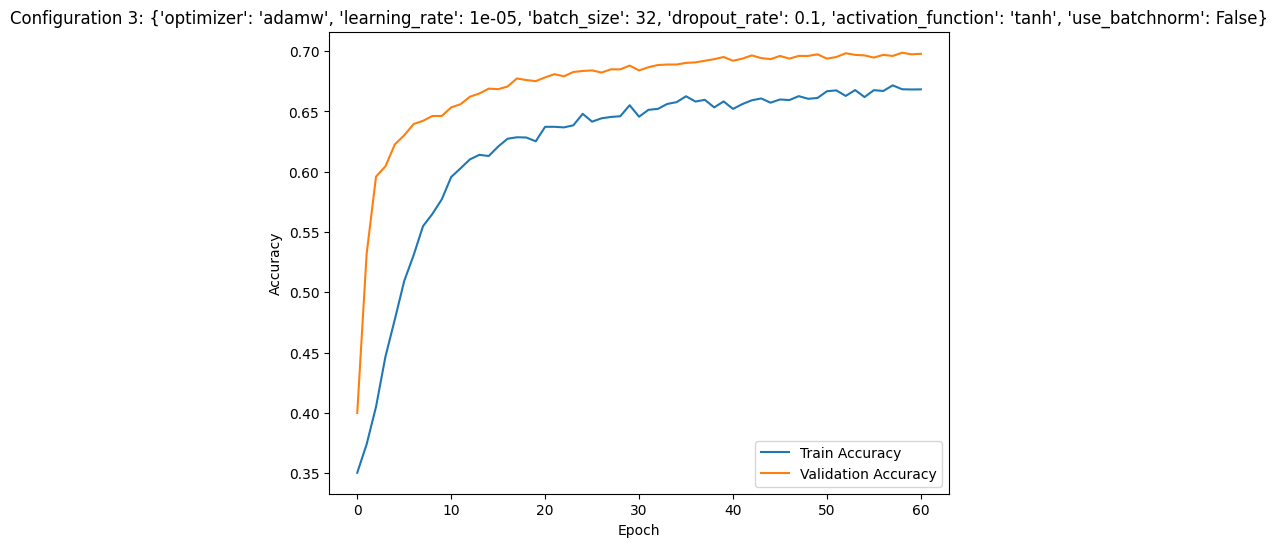

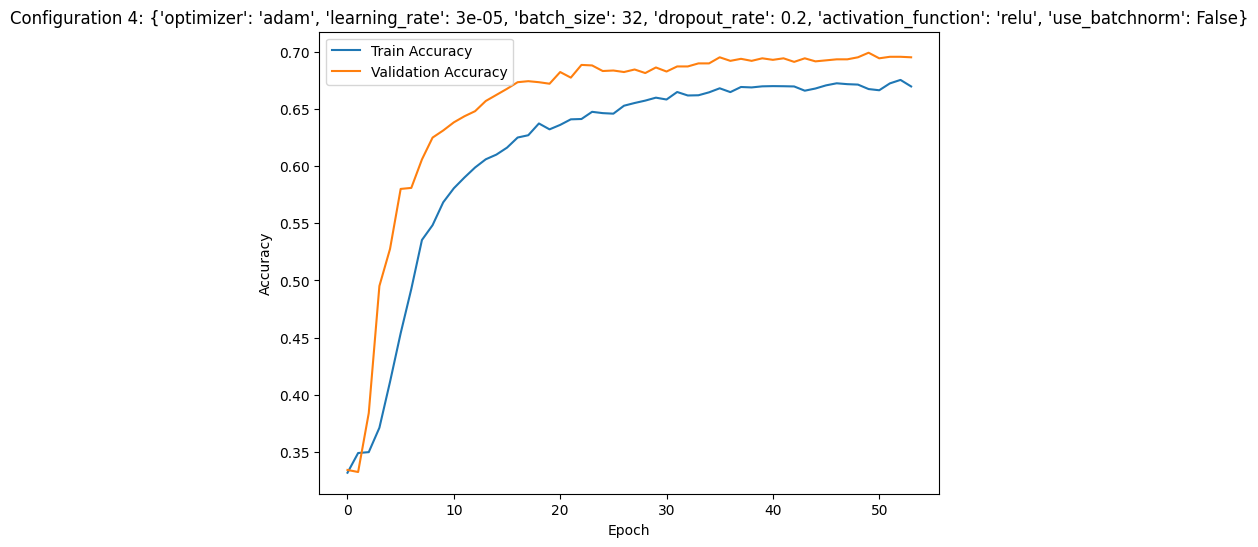

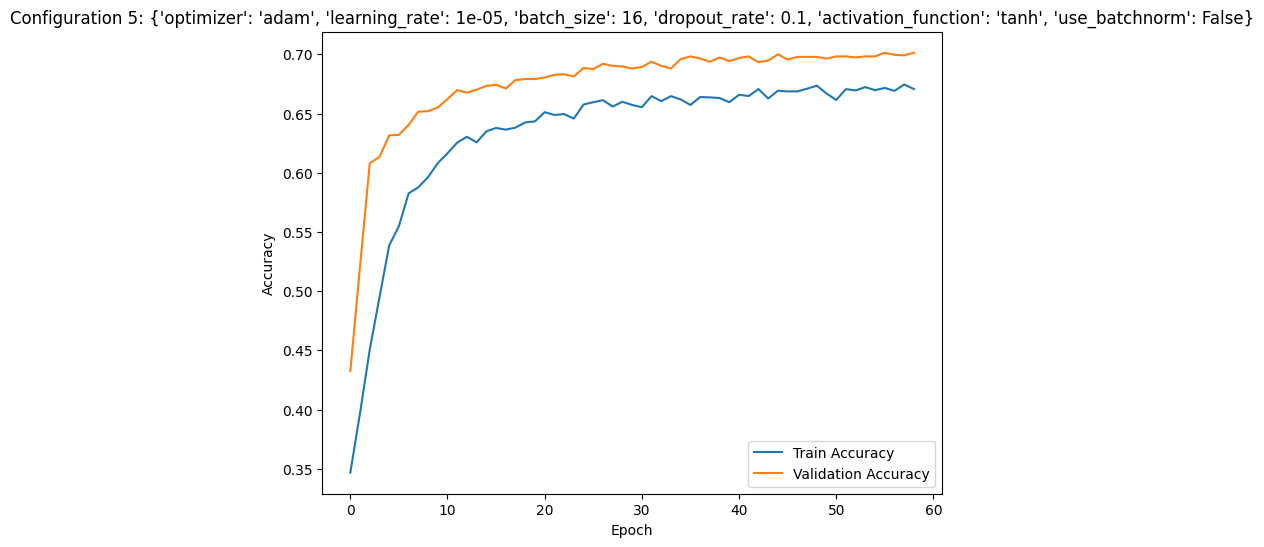

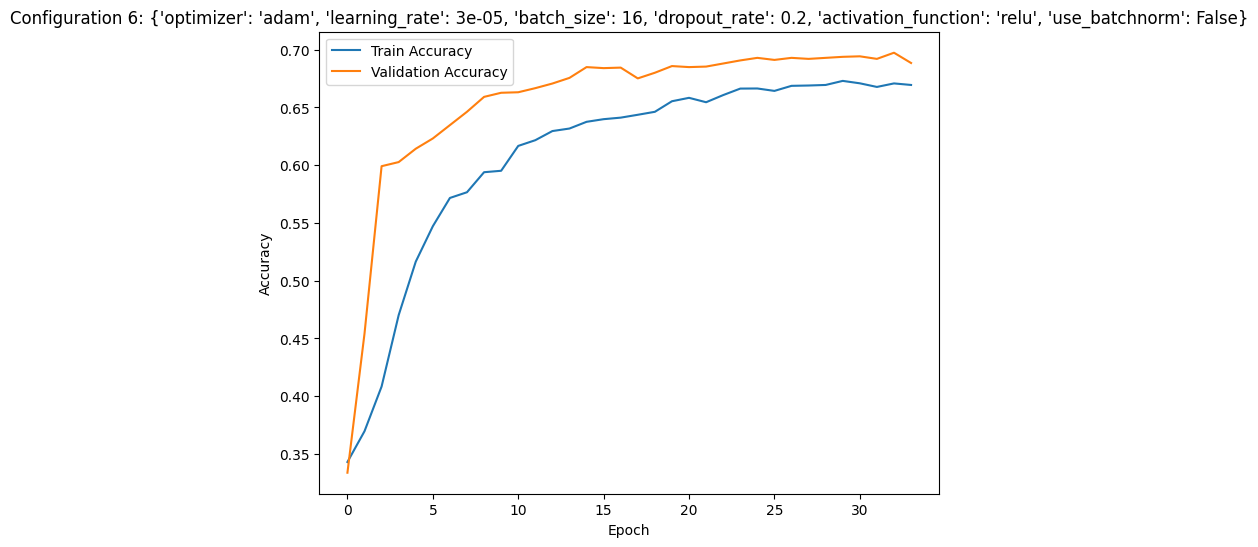

In [46]:
# Visualize the results

# Plot training and validation accuracy for each configuration
for i, (history, config) in enumerate(histories):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Configuration {i+1}: {config}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


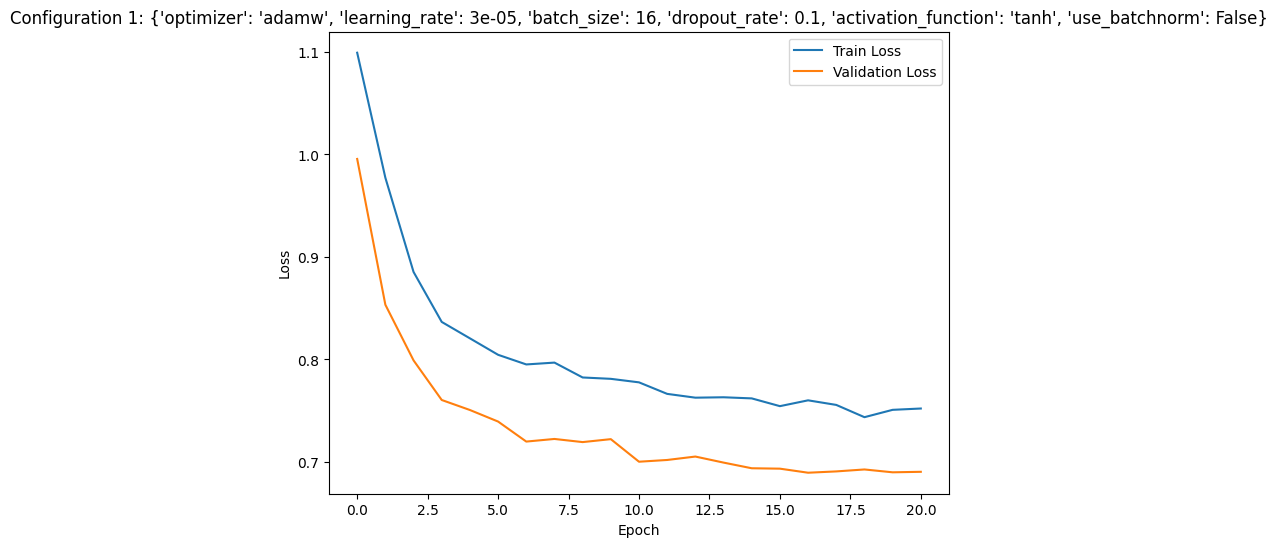

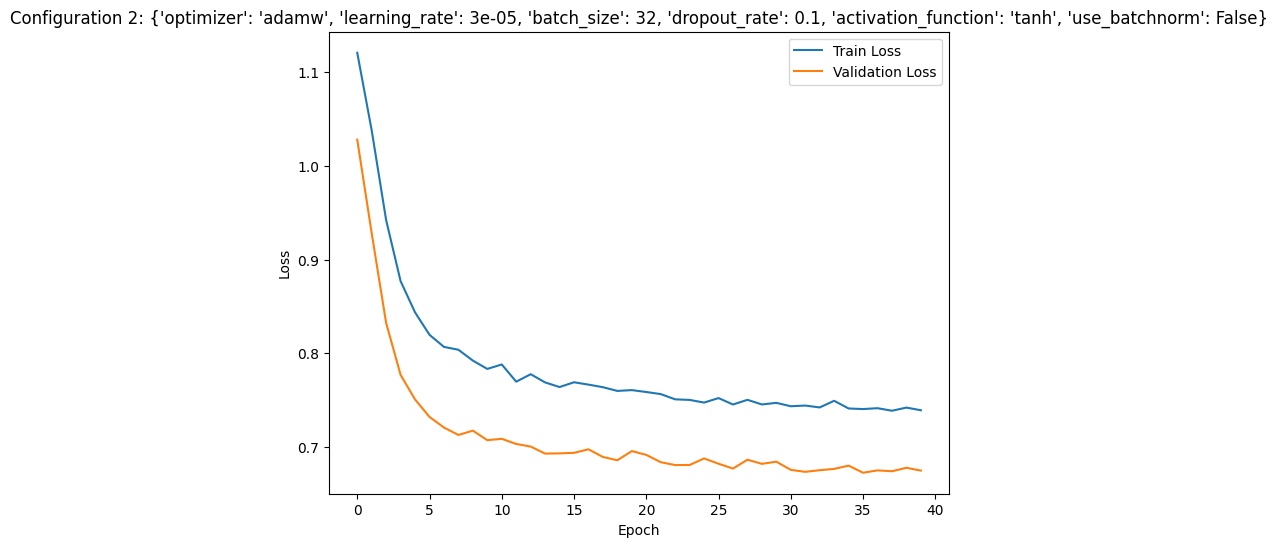

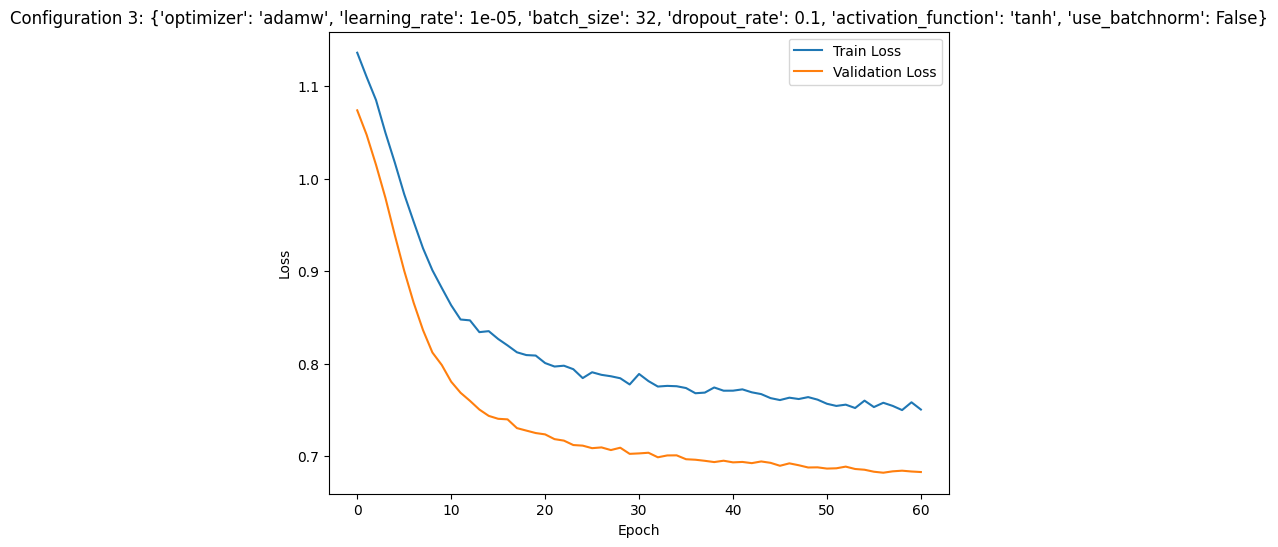

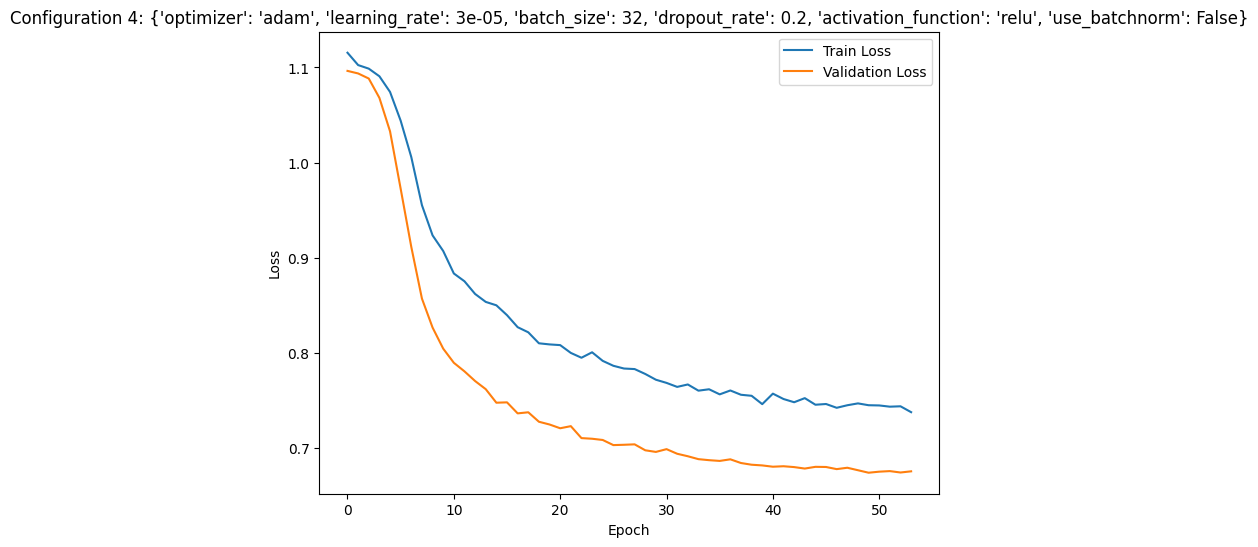

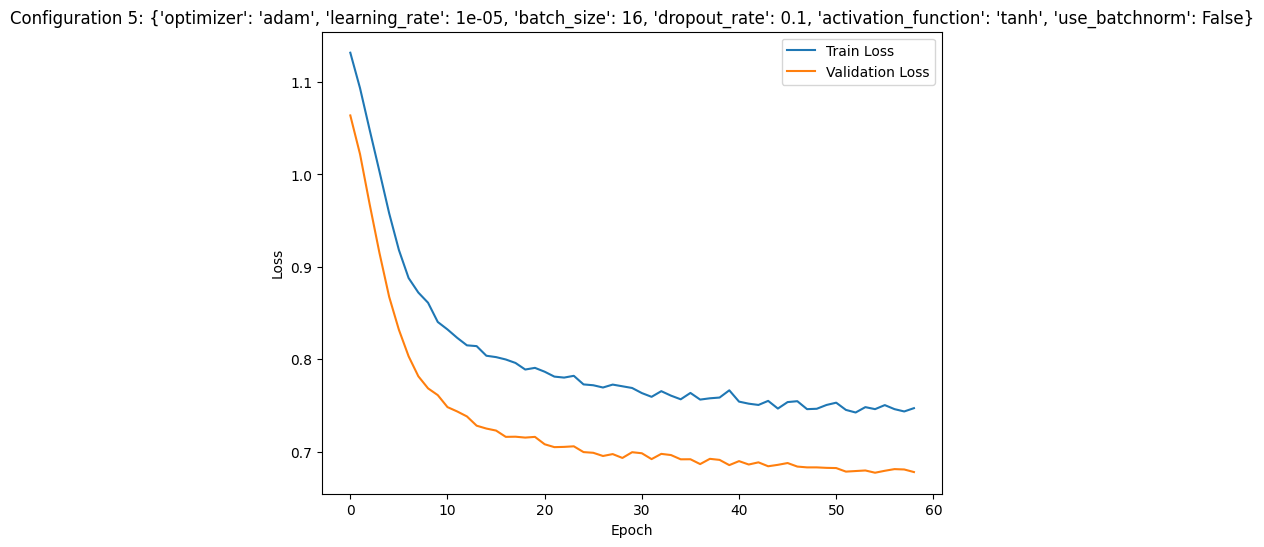

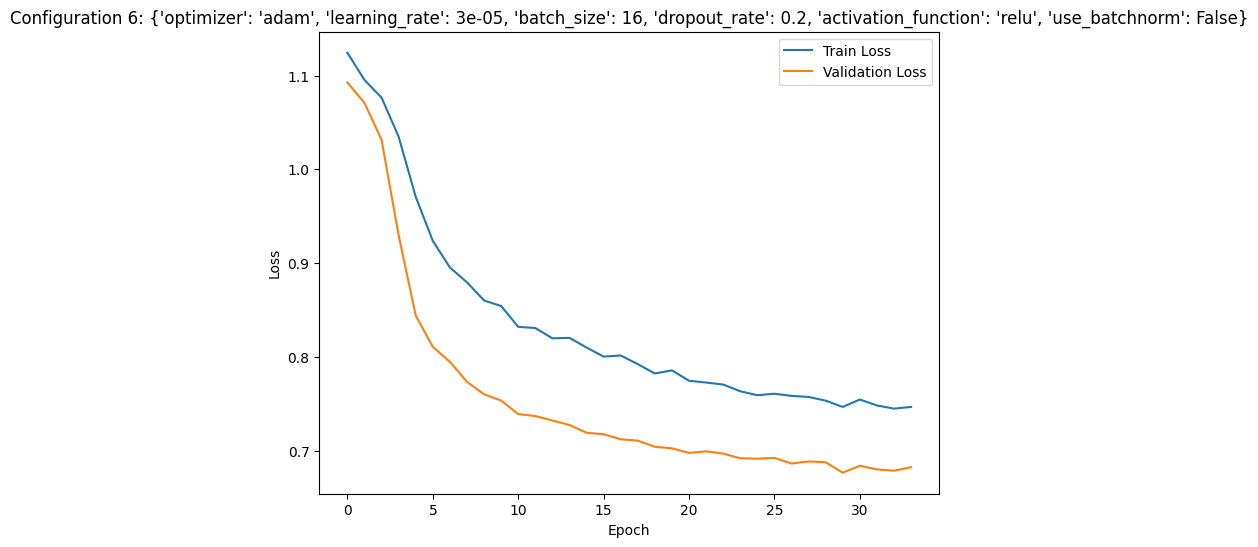

In [47]:
# Plot training and validation loss for each configuration
for i, (history, config) in enumerate(histories):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Configuration {i+1}: {config}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [48]:
# Create a DataFrame of the results
results_df = pd.DataFrame([{
    'optimizer': res['config']['optimizer'],
    'learning_rate': res['config']['learning_rate'],
    'batch_size': res['config']['batch_size'],
    'dropout_rate': res['config']['dropout_rate'],
    'activation_function': res['config']['activation_function'],
    'use_batchnorm': res['config']['use_batchnorm'],
    'accuracy': res['accuracy'],
    'loss': res['loss']
} for res in results])

print(results_df)

   optimizer  learning_rate  batch_size  dropout_rate activation_function  \
0      adamw        0.00003          16           0.1                tanh   
1      adamw        0.00003          16           0.1                tanh   
2      adamw        0.00003          32           0.1                tanh   
3      adamw        0.00003          32           0.1                tanh   
4      adamw        0.00001          32           0.1                tanh   
5      adamw        0.00001          32           0.1                tanh   
6       adam        0.00003          32           0.2                relu   
7       adam        0.00003          32           0.2                relu   
8       adam        0.00001          16           0.1                tanh   
9       adam        0.00001          16           0.1                tanh   
10      adam        0.00003          16           0.2                relu   
11      adam        0.00003          16           0.2                relu   

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
657/657 [==============================] - 156s 217ms/step - loss: 0.7083 - accuracy: 0.6799 - val_loss: 0.5798 - val_accuracy: 0.7462
Epoch 2/10
657/657 [==============================] - 134s 204ms/step - loss: 0.5649 - accuracy: 0.7679 - val_loss: 0.6187 - val_accuracy: 0.7356
Epoch 3/10
657/657 [==============================] - 134s 204ms/step - loss: 0.4767 - accuracy: 0.8105 - val_loss: 0.6324 - val_accuracy: 0.7493
Epoch 4/10
141/141 [==============================] - 10s 73ms/step - loss: 0.6086 - accuracy: 0.7311
Test accuracy: 0.7311111092567444
141/141 [==============================] - 12s 72ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.69      0.74       773
     Neutral       0.63      0.66      0.64       741
    Positive       0.78      0.85      0.81       736

    accuracy                           0.73      2250
   macro avg       0.73      0.73      0.73      2250
weighted avg       0

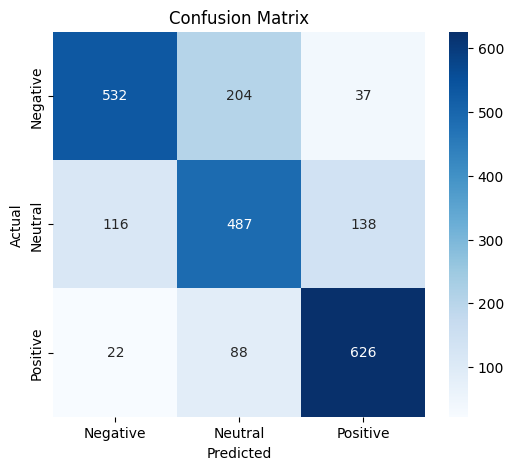

In [49]:
from transformers import TFRobertaForSequenceClassification

# Load the pre-trained distilroberta model for sequence classification
model = TFRobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=3)

# Freeze the first 3 encoder layers
for layer in model.roberta.encoder.layer[:3]:
    layer.trainable = False

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# Define the loss with from_logits=True
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

# Set batch size and create datasets
batch_size = 16
train_dataset = create_tf_dataset(train_input_ids, train_attention_mask, train_labels, batch_size)
val_dataset = create_tf_dataset(val_input_ids, val_attention_mask, val_labels, batch_size)
test_dataset = create_tf_dataset(test_input_ids, test_attention_mask, test_labels, batch_size)

# Set up callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model using the validation set
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# Record the history and config
histories.append((history, {'learning_rate': 3e-5, 'batch_size': 16}))

# Evaluate the final model on the test set
loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy}")

# Store results
results.append({
    'learning_rate': 3e-5,
    'batch_size': 16,
    'accuracy': accuracy,
    'loss': loss,
})

# Generate predictions for the test set
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs.logits, axis=1)

# Flatten test labels
y_true = test_labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(f"Classification Report:\n{report}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix')
plt.show()

# Store results
results.append({
    'learning_rate': 3e-5,
    'batch_size': 16,
    'accuracy': accuracy,
    'loss': loss,
    'confusion_matrix': cm,
    'classification_report': report
})

# If current model is better, save it

# Clear previous best model from memory if exists

best_accuracy = accuracy
best_model = model
best_config = {'learning_rate': 3e-5, 'batch_size': 16}
best_y_pred = y_pred
best_y_true = y_true
# Also store confusion matrix and classification report
best_cm = cm
best_report = report

In [51]:
# Save the best model to a .keras file
best_model.save('best_model.keras')
print("\nBest model saved to 'best_model.keras'.")

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)



Best model saved to 'best_model.keras'.


In [50]:
# After the training loop
print(f"\nBest Model Configuration: {best_config}")
print(f"Best Model Test Accuracy: {best_accuracy}")

# Use the best model's predictions
y_pred = best_y_pred
y_true = best_y_true

# Identify misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]

# Decode test texts
def decode_texts(input_ids):
    return [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

test_texts = decode_texts(test_input_ids)

# Extract false positives and false negatives
false_positives = []
false_negatives = []

# Mapping of label indices to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Loop through misclassified examples to separate false positives and false negatives
for idx in misclassified_indices:
    true_label = y_true[idx]
    predicted_label = y_pred[idx]
    text = test_texts[idx]

    if predicted_label == 2 and true_label != 2:
        # Model predicted Positive, but true label is Negative or Neutral
        false_positives.append((text, label_map[true_label], label_map[predicted_label]))
    elif predicted_label != 2 and true_label == 2:
        # Model predicted Negative or Neutral, but true label is Positive
        false_negatives.append((text, label_map[true_label], label_map[predicted_label]))

# Display a few examples of false positives
print("\nExamples of False Positives:")
for i in range(min(3, len(false_positives))):
    text, true_label, predicted_label = false_positives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")

# Display a few examples of false negatives
print("\nExamples of False Negatives:")
for i in range(min(3, len(false_negatives))):
    text, true_label, predicted_label = false_negatives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")


Best Model Configuration: {'learning_rate': 3e-05, 'batch_size': 16}
Best Model Test Accuracy: 0.7311111092567444

Examples of False Positives:

Text: this is quite good ive taken to starting my mornings with a nice hot mug
True Label: Neutral
Predicted Label: Positive

Text: i love gloria jeans cinnamon nut strudel coffee and decided to try this the flavoring is a little over powering for me if youve tried this flavor before and like it you wont be disappointed with it in the kcups packaging
True Label: Neutral
Predicted Label: Positive

Text: im an espresso nut and have several machines that i call my friends one of these is a jura s avantgarde and after trying dozens and dozens of various beans to find the perfect mate intelligentsia black cat classic prevailed as the very clear winner there may be better beans out there but not for this machine ive served thousands of shots of this espresso out of the jura and everyone is impressed by it actually not just impressed blown away its 

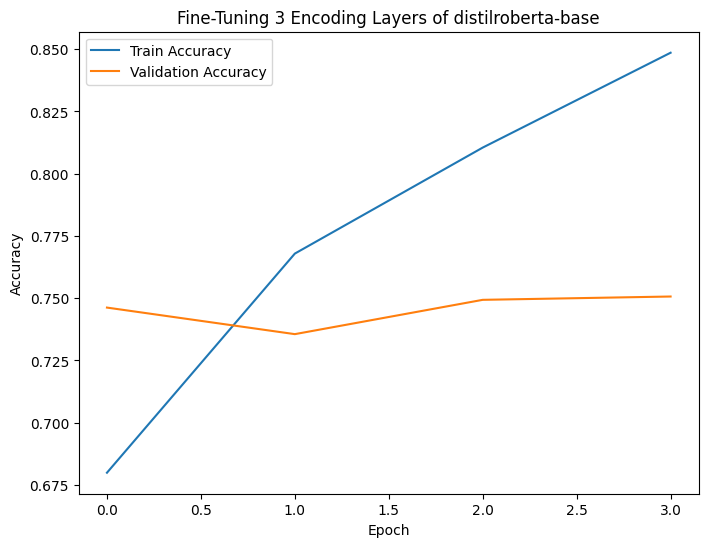

In [55]:
# Plot training and validation accuracy for each configuration
for i, (history, config) in enumerate(histories):
  if i == 6:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Fine-Tuning 3 Encoding Layers of distilroberta-base")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
  else:
    None